<a href="https://colab.research.google.com/github/anadiedrichs/2023-nlp-tps/blob/main/4_text_generation_lstm_nlp_AlfonsinaStorni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Cargamos las librerias para generar modelos LSTM
import sys
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

In [15]:
!wget https://www.dropbox.com/scl/fi/xiac9gr5mcpgz4hckl0w8/antologia-alfonsina-storni.txt?rlkey=0f6ryz575grttiz3sp7ein9l9&dl=1
!ls -la

--2023-08-28 14:44:22--  https://www.dropbox.com/scl/fi/xiac9gr5mcpgz4hckl0w8/antologia-alfonsina-storni.txt?rlkey=0f6ryz575grttiz3sp7ein9l9
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/xiac9gr5mcpgz4hckl0w8/antologia-alfonsina-storni.txt?rlkey=0f6ryz575grttiz3sp7ein9l9 [following]
--2023-08-28 14:44:22--  https://www.dropbox.com/e/scl/fi/xiac9gr5mcpgz4hckl0w8/antologia-alfonsina-storni.txt?rlkey=0f6ryz575grttiz3sp7ein9l9
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95635c6d4b43474d621344e168.dl.dropboxusercontent.com/cd/0/inline/CCrGHv0YZXbwBLy53zpYJlx0FADYAyig5-UabIeQkCWXjMkP5TZ30XG4OJAnQuWRff8AR5xw6tBqPGQi7rqRNTz2cH5SuEq89l5LMkiVOIozxhjuDcWo_1Lcn1M682lxwmY/file# [following]
--2023-08-28 14:44:23

In [16]:
! cat 'antologia-alfonsina-storni.txt?rlkey=0f6ryz575grttiz3sp7ein9l9' > alfonsina.txt

In [17]:
!ls -la

total 95412
drwxr-xr-x 1 root root    4096 Aug 28 14:44  .
drwxr-xr-x 1 root root    4096 Aug 28 14:19  ..
-rw-r--r-- 1 root root  172859 Aug 28 14:44  alfonsina.txt
-rw-r--r-- 1 root root  172859 Aug 28 14:21 'antologia-alfonsina-storni.txt?rlkey=0f6ryz575grttiz3sp7ein9l9'
-rw-r--r-- 1 root root  172859 Aug 28 14:44 'antologia-alfonsina-storni.txt?rlkey=0f6ryz575grttiz3sp7ein9l9.1'
drwxr-xr-x 4 root root    4096 Aug 24 21:24  .config
drwxr-xr-x 1 root root    4096 Aug 24 21:25  sample_data
-rw-r--r-- 1 root root 9713840 Aug 28 14:24  weights-improvement-01-2.7786-bigger.hdf5
-rw-r--r-- 1 root root 9713840 Aug 28 14:25  weights-improvement-02-2.5485-bigger.hdf5
-rw-r--r-- 1 root root 9713840 Aug 28 14:26  weights-improvement-03-2.4570-bigger.hdf5
-rw-r--r-- 1 root root 9713840 Aug 28 14:27  weights-improvement-04-2.3853-bigger.hdf5
-rw-r--r-- 1 root root 9713840 Aug 28 14:28  weights-improvement-05-2.3222-bigger.hdf5
-rw-r--r-- 1 root root 9713840 Aug 28 14:29  weights-improvement-06-2

In [18]:
# cargar texto plano y convertir a UTF-8 para normalizar
filename = "alfonsina.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()


In [19]:
# Crear un mapeo de caracteres a nros enteros
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))


In [20]:
# Resumen de los datos cargados
n_chars = len(raw_text)
n_vocab = len(chars)
print("Nro de caracteres: ", n_chars)
print("Total vocablos: ", n_vocab)

Nro de caracteres:  169327
Total vocablos:  63


In [21]:
# Prepara un conjunto de datos con pares de entrada / salida o [input / output] codificada como enteros
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total de patrones o tamaño del dataset: ", n_patterns)

Total de patrones o tamaño del dataset:  169227


In [22]:
# reshape X para armar el dataset [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalizar
X = X / float(n_vocab)
# one hot encode la variable de salida
y = to_categorical(dataY)
# el modelo:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
# guardar un checkpoint, el modelo luego de cada epoch, por las dudas
filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# entrenamiento del modleo
history = model.fit(X, y, epochs=10, batch_size=64, callbacks=callbacks_list)

Epoch 1/10
2643/2645 [============================>.] - ETA: 0s - loss: 2.7413
Epoch 1: loss improved from inf to 2.74125, saving model to weights-improvement-01-2.7413-bigger.hdf5
2645/2645 [==============================] - 55s 19ms/step - loss: 2.7413
Epoch 2/10
2643/2645 [============================>.] - ETA: 0s - loss: 2.5237
Epoch 2: loss improved from 2.74125 to 2.52370, saving model to weights-improvement-02-2.5237-bigger.hdf5
2645/2645 [==============================] - 53s 20ms/step - loss: 2.5237
Epoch 3/10
2643/2645 [============================>.] - ETA: 0s - loss: 2.4131
Epoch 3: loss improved from 2.52370 to 2.41301, saving model to weights-improvement-03-2.4130-bigger.hdf5
2645/2645 [==============================] - 50s 19ms/step - loss: 2.4130
Epoch 4/10
2643/2645 [============================>.] - ETA: 0s - loss: 2.3304
Epoch 4: loss improved from 2.41301 to 2.33033, saving model to weights-improvement-04-2.3303-bigger.hdf5
2645/2645 [==============================]

Graficamos las métricas de entrenamiento del modelo

In [23]:
print(history.history.keys())

dict_keys(['loss'])


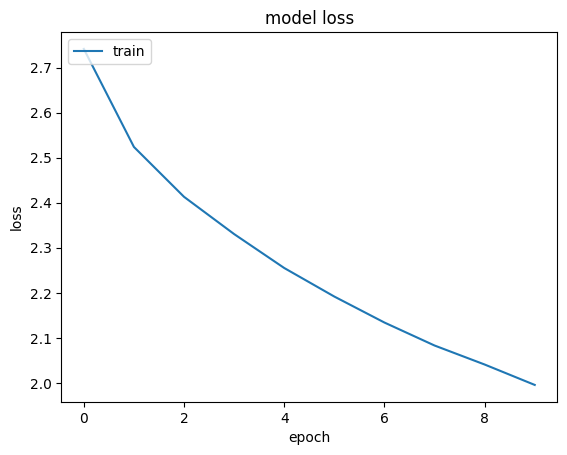

In [25]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]

print("[INICIO DE LA GENERACION de texto, caracter por caracter].")
print("Semilla o texto inicial:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(100):
	x = np.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("[GENERACION TERMINADA].")

[INICIO DE LA GENERACION de texto, caracter por caracter].
Semilla o texto inicial:
" ndes y no miras;

pero entiendes y miras, y le sueltas

con mucho disimulo,

como quien no quisiera, "






el cielo


en el corazón de la cabeza

de la cabeza 
de la cabeza

de la cabeza

de la cabeza
[GENERACION TERMINADA].


**CONCLUSIONES**


Para mejorar el modelo podría probarse:

* Preprocesar mejor el texto, quitando los sucesivos espacios en blanco y caracteres especiales o símbolos extras de puntuación (<< o dobles llaves)

* Probar utilizar one-hot encoding para las secuencias de entrada.

* Entrenar un modelo con oraciones completas en lugar de secuencias aleatorias de caracteres.

* Entrenar por más épocas

* Cambie las capas de LSTM para que tengan "estado" (statefull) para mantener el estado en todos los lotes